# Reflection Matrix in Gaussian-Beam Basis

In this example, we compute the reflection matrix of an open system with the input and output bases being Gaussian beams focused to different spatial locations. The magnitude of the diagonal elements of this matrix corresponds to what is measured in confocal microscopy. We first build the list of inputs B and list of outputs C, and then use mesti() to compute the reflection matrix.

In [1]:
# Call necessary packages
using MESTI, GeometryPrimitives, Plots

# Build the system


In this example, we consider a test system of a dielectric cylindrical scatterer located at (*y*<sub>0</sub>, *z*<sub>0</sub>) in air.

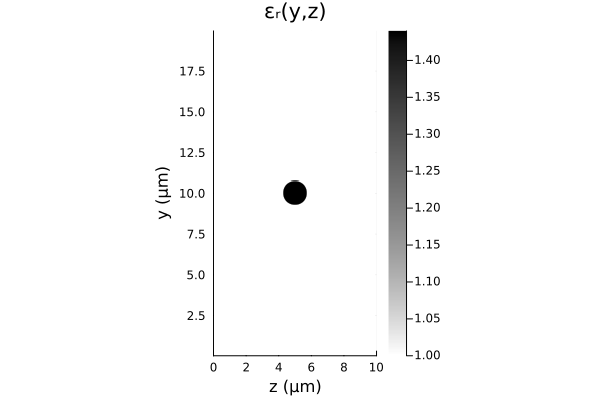

In [2]:
syst = Syst()
syst.length_unit = "µm"
syst.wavelength = 1.0 # wavelength (µm)
syst.dx = syst.wavelength/15 # discretization grid size (µm)
nPML = 20    # number of PML pixels
W = 20       # width of simulation domain (including PML) (µm)
L = 10       # length of simulation domain (including PML) (µm)
r_0 = 0.75   # cylinder radius (µm)
n_bg   = 1.0 # refractive index of the background
n_scat = 1.2 # refractive index of the cylinder
y_0 = W/2    # location of the cylinder
z_0 = L/2    # location of the cylinder

# Build the relative permittivity profile from subpixel smoothing
domain = Cuboid([W/2,L/2], [W,L]) # domain for subpixel smoothing cetering at (W/2, L/2) and with witdth W and thickness L
domain_epsilon = n_bg^2 # epsilon of the domain for subpixel smoothing
object = [Ball([y_0, z_0], r_0)] # object for subpixel smoothing: cylinder locate at (W/2, L/2) with radius r_0
object_epsilon = [n_scat^2] # epsilon of the object for subpixel smoothing
yBC = "PEC"; zBC = "PEC" # boundary conditions
epsilon_xx = mesti_subpixel_smoothing(syst.dx, domain, domain_epsilon, object, object_epsilon, yBC, zBC) # obtaining epsilon_xx from mesti_subpixel_smoothing()

ny_Ex, nz_Ex = size(epsilon_xx)
y = syst.dx:syst.dx:(W-syst.dx/2)
z = syst.dx:syst.dx:(L-syst.dx/2)

# Plot the relative permittivity profile
heatmap(z, y, epsilon_xx, 
       aspect_ratio=:equal, 
       xlabel = "z (µm)", ylabel = "y (µm)", 
       xlims=(0,10), title="εᵣ(y,z)",   
       c = cgrad(:grayC, rev=true))

# Build the input sources

We consider inputs being Gaussian beams focused at (*y*<sub>f</sub>, *z*<sub>f</sub>). In this example, we fix the focal depth at  *z*<sub>f</sub> = *z*<sub>0</sub> (i.e., the depth of the scatterer), and scan the transverse coordinate *y*<sub>f</sub> of the focus.

Perfect Gaussian beams can be generated with the total-field/scattered-field (TF/SF) method. But since the cross section of the beam decays exponentially in *y*, we can generate Gaussian beams to a high accuracy simply by placing line sources at a cross section on the left, which is what we do here. We place the line sources at *z* = *z*<sub>source</sub>, just in front of the PML.

To determine the required line sources, we (1) take the field profile of the desired incident Gaussian beam at the focal plane, *E*<sup>in</sup>(*y*,*z*<sub>f</sub>) = *E*<sub>0</sub>exp(-(*y* - *y*<sub>f</sub>)<sup>2</sup>/*w*<sup>2</sup>), (2) project it onto the propagating channels (i.e., ignoring evanescent contributions) of free space, (3) back propagate it to the source plane to determine *E*<sup>in</sup>(*y*,*z*<sub>source</sub>) in the propagating-channel basis, and (4) determine the line source necessary to generate such *E*<sup>in</sup>(*y*,*z*<sub>source</sub>).

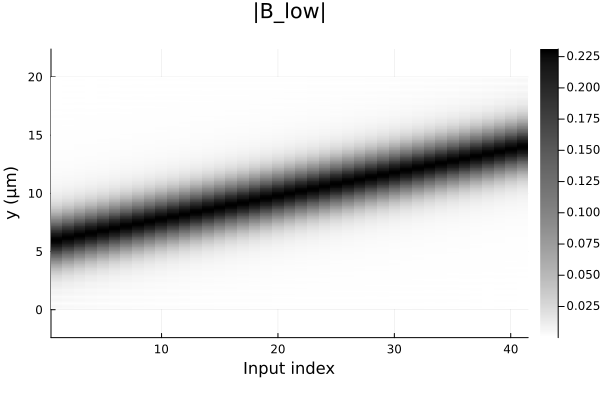

In [3]:
# Parameters of the input Gaussian beams
NA = 0.5   # numerical aperture
z_f = z_0  # location of the focus in z (fixed)
y_f_start = 0.3*W # starting location of the focus in y 
y_f_end   = 0.7*W # ending location of the focus in y
dy_f = syst.wavelength/(10*NA)  # spacing of focal spots in y

# Parameters of the line sources
n_source = nPML + 1 # index of the source plane
z_source = z[n_source] # location of the source plane

w_0 = syst.wavelength/(pi*NA) # beam radius at z = z_f
y_f = y_f_start:dy_f:y_f_end # list of focal positions in y
M_in = length(y_f) # number of inputs

# Step 1: Generate the list of E^in(z=z_f, y).
# Here, y is an ny_Ex-by-1 column vector, and y_f is a M_in-by-1 column vector.
# So, y .- transpose(y_f) is an ny_Ex-by-M_in matrix by implicit expansion.
# Then, E_f is an ny_Ex-by-M_in matrix whose m-th column is the cross section
# of the m-th Gaussian beam at z = z_f.
E_f = exp.(-(y .- transpose(y_f)).^2/(w_0^2)) # size(E_f) = [ny_Ex, M_in]

# Get properties of propagating channels in the free space.
# We use PEC as the boundary condition for such channels since the default
# boundary condition in mesti() is PEC for TM waves, but the choice has
# little effect since E^in should be exponentially small at the boundary of
# the simulation domain.
channels = mesti_build_channels(ny_Ex, "PEC", (2*pi/syst.wavelength)*syst.dx, n_bg^2)

# Transverse profiles of the propagating channels. Each column of u is
# one transverse profile. Different columns are orthonormal.
u = channels.u_x_m(channels.kydx_prop) # size(u) = [ny_Ex, N_prop]

# Step 2: Project E^in(y, z_f) onto the propagating channels.
E_f_prop = u'*E_f # size(E_f_prop) = [N_prop, M_in]

# Step 3: Back propagate from z = z_f to z = z_source.
# This step assumes a PEC boundary in y, so it is not exact with PML in y,
# but it is sufficiently accurate since E^in decays exponentially in y.
# Note we use implicit expansion here.
kz = reshape(channels.kzdx_prop/syst.dx, :, 1) # list of wave numbers
E_s_prop = exp.(1im*kz*(z_source-z_f)).*E_f_prop # size(E_s_prop) = [N_prop, M_in]

# Step 4: Determine the line sources.
# In a closed geometry with no PML in y, a line source of
# -2i*nu[a]*u[:,a] generates outgoing waves with transverse profile
# u[:,a]. With PML in y, this is not strictly true but is sufficiently
# accurate since E^in(y,z=z_source) decays exponentially in y.
# Note we use implicit expansion here.
nu = reshape(channels.sqrt_nu_prop, :, 1).^2 # nu = sin(kz*dx)
B_low = u*(nu.*E_s_prop) # size(B_low) = [ny_Ex, M_in]

# We take the -2i prefactor out, to be multiplied at the end. The reason
# will be clear when we handle C below.
opts = Opts()
opts.prefactor = -2im

# In mesti(), Bx.pos = [m1, l1, w, h] specifies the position of a
# block source, where (m1, l1) is the index of the smaller-(y,z) corner,
# and (w, h) is the width and height of the block. Here, we put line
# sources (w=1) at l1 = l_source that spans the whole width of the
# simulation domain (m1=1, h=ny_Ex).
Bx = Source_struct()
Bx.pos = [[1, n_source, ny_Ex, 1]]

# Bx.data specifies the source profiles inside such block, with
# Bx.data[1][:, a] being the a-th source profile.
Bx.data = [B_low]

# We check that the input sources are sufficiently localized with little 
# penetration into the PML; otherwise the Gaussian beams will not be
# accurately generated.
heatmap(1:M_in, collect(y), abs.(B_low), 
        aspect_ratio=:equal, 
        xlabel = "Input index", ylabel = "y (µm)", 
        title="|B_low|", c =cgrad(:grayC, rev=true))

# Build the output projections

We consider output projections onto the same set of Gaussian beams focused at (*y*<sub>f</sub>, *z*<sub>f</sub>), with the projection done at the same plane as the source plane (*z* = *z*<sub>source</sub>).

When the system has a closed boundary in *y*, as is the case in mesti2s(), the set of transverse modes form a complete and orthonormal basis, so it is clear what the output projection should be. But the Gaussian beams here are not orthogonal to each other, are not normalized, and do not form a complete basis. So, it is not obvious how our output projection should be defined.

What we do here is to convert everything onto the complete and orthonormal basis of transverse modes, and do the projection in such basis while accounting for the flux. Specifically, we (1) project the total field at the source plane, *E*<sup>tot</sup>(*y*,*z*<sub>source</sub>) = *E*<sup>in</sup>(*y*,*z*<sub>source</sub>) + *E*<sup>sca</sup>(*y*,*z*<sub>source</sub>), onto the propagating channels (i.e., ignoring evanescent contributions) of free space; the incident contribution will be subtracted later (2) back propagate such reflection to the focal plane at *z* = *z*<sub>f</sub> since the *E*<sup>sca</sup>(*y*,*z*<sub>source</sub>) component supposedly comes from reflection, (3) take the previously computed Gaussian beams at the focal plane projected onto propagating channels of free space, and (4) take the inner product between the two while accounting for the longitudinal flux of the different propagating channels.

Above, the incident field *E*<sup>in</sup>(*y*,*z*) was not subtracted. Contribution from the incident field will be subtracted using matrix D in the next step.

In [4]:
# We perform the output projection on the same plane as the line source
Cx = Source_struct()
Cx.pos = Bx.pos

# Step 1: Project E_x^tot(y, z_source) onto the propagating channels.
# The projection will be C_low*E_x^tot(:,l_source)
C_low = u' # size(C_low) = [N_prop, ny_Ex]

# Step 2: Back propagate from z = z_source to z = z_f
C_low = exp.(-1im*kz*(z_f-z_source)).*C_low # size(C_low) = [N_prop, ny_Ex]

# Step 3: Project Gaussian beams at the focal plane onto the propagating
# channels. No need to repeat since this was already done earlier.
# E_f_prop = u'*E_f; # size(E_f_prop) = [N_prop, M_in]

# Step 4: Take the inner product between the two
# The longitudinal flux of a propagating channels is proportional to nu, so
# we weight the inner product with nu to account for flux dependence.
# Note we use implicit expansion here.
C_low = (E_f_prop') * (nu.*C_low) # size(C_low) = [M_in, ny_Ex]

# Normally, the next step would be
# C_struct.data = C_low.';
# However, we can see that C_low equals transpose(B_low)
println("max(|C_low-transpose(B_low)|) = $(maximum(abs.(C_low - transpose(B_low))))")

max(|C_low-transpose(B_low)|) = 1.1631705747361534e-16


In [5]:
# That means we will have C = transpose(B). So, we can save some computing
# time and memory usage by specifying C = transpose(B).
# This is expected by reciprocity -- when the set of inputs equals the set
# of outputs, we typically have C = transpose(B) or its permutation.
C_x = nothing
C = "transpose(B)";

# Compute reflection matrix in Gaussian-beam basis

The scattering matrix is given by S = C\*inv(A)\*B - D, with D = C\*inv(A<sub>0</sub>)\*B - S<sub>0</sub> where A<sub>0</sub> is a reference system for which its scattering matrix S<sub>0</sub> is known. We consider A<sub>0</sub> to be a homogeneous space with no scatterers, for which the reflection matrix S<sub>0</sub> is zero.

In [6]:
syst.PML = [PML(nPML)] # Put PML on all four sides

# For a homogeneous space, the length of the simulation domain doesn't
# matter, so we choose a minimal thickness of nz_Ex_temp = n_source + nPML
# where n_source = nPML + 1 is the index of the source plane.
syst.epsilon_xx = n_bg^2*ones(ny_Ex, n_source + nPML)
D, _ = mesti(syst, [Bx], C, opts);

===System size=== 
ny_Ex = 299; nz_Ex = 41 for Ex(y,z) 
UPML on -y +y -z +z sides; ; yBC = PEC; zBC = PEC
Building B,C... elapsed time:   0.796 secs
Building A  ... elapsed time:   3.315 secs
< Method: APF using MUMPS in single precision with AMD ordering (symmetric K) >
Building K  ... elapsed time:   0.942 secs
Analyzing   ... elapsed time:   0.058 secs
Factorizing ... elapsed time:   0.032 secs
          Total elapsed time:   8.145 secs


In [7]:
# Compute the reflection matrix
syst.epsilon_xx = epsilon_xx
r, _ = mesti(syst, [Bx], C, D, opts);

===System size=== 
ny_Ex = 299; nz_Ex = 149 for Ex(y,z) 
UPML on -y +y -z +z sides; ; yBC = PEC; zBC = PEC
Building B,C... elapsed time:   0.001 secs
Building A  ... elapsed time:   0.515 secs
< Method: APF using MUMPS in single precision with AMD ordering (symmetric K) >
Building K  ... elapsed time:   0.466 secs
Analyzing   ... elapsed time:   0.022 secs
Factorizing ... elapsed time:   0.081 secs
          Total elapsed time:   2.163 secs


# Compute the full field profile

For most applications, it is not necessary to compute the full field profile, since most experiments measure properties in the far field. Here, we compute the full field profile for the purpose of visualizing the system as the incident Gaussian beams are scanned across *y*.

In [8]:
# Exclude the PML pixels from the returned field profiles
opts.exclude_PML_in_field_profiles = true
y_interior = y[(nPML+1):(ny_Ex-nPML)]
z_interior = z[(nPML+1):(nz_Ex-nPML)]

field_profiles, _ = mesti(syst, [Bx], opts);

===System size=== 
ny_Ex = 299; nz_Ex = 149 for Ex(y,z) 
UPML on -y +y -z +z sides; ; yBC = PEC; zBC = PEC
Building B,C... elapsed time:   0.001 secs
Building A  ... elapsed time:   0.488 secs
< Method: factorize_and_solve using MUMPS in single precision with AMD ordering >
Analyzing   ... elapsed time:   0.020 secs
Factorizing ... elapsed time:   0.084 secs
Solving     ... elapsed time:   0.348 secs
          Total elapsed time:   0.655 secs


# Animate the field profiles

[ Info: Saved animation to /project/cwhsu_38/hochunli/JupyterLab/reflection_matrix_Gaussian_beams.gif


Plots.AnimatedGif("/project/cwhsu_38/hochunli/JupyterLab/reflection_matrix_Gaussian_beams.gif")
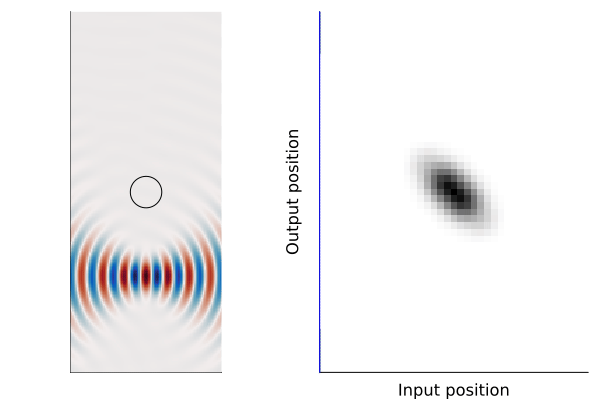

In [9]:
theta = range(0, 2*pi, 100)
circ_x = cos.(theta)
circ_y = sin.(theta)

# Loop through Gaussian beams focused at different locations.
anim = @animate for ii ∈ 1:M_in
    plt1 = heatmap(collect(z_interior), collect(y_interior), real(field_profiles[:, :, ii]), 
                   xlims=(z_interior[1], z_interior[end]), aspect_ratio=:equal, 
                   c = :balance, xticks = false, yticks = false, colorbar = false)
    plot!(plt1, z_0.+r_0*circ_x, y_0.+r_0*circ_y, lw=1, color=:black, 
          xlims=(z_interior[1], z_interior[end]), ylims=(y_interior[1], y_interior[end]), legend=false)

    plt2 = heatmap(collect(y_f), collect(y_f), abs.(r).^2, 
                   xlims=(6,14), aspect_ratio=:equal, 
                   xlabel = "Input position", ylabel = "Output position",
                   c =cgrad(:grayC, rev=true), xticks = false, yticks = false, colorbar = false)
    plot!(plt2, [y_f[ii]], seriestype = :vline, linecolor=:blue, legend=false)    
    plot(plt1, plt2, layout = (1, 2))  
end
gif(anim, "reflection_matrix_Gaussian_beams.gif", fps = 10)